In [1]:
import pandas as pd
import numpy as np
import json
import os
import shutil

from skimage import io, draw
from collections import defaultdict
from matplotlib import pyplot as plt

In [4]:
path = os.path.join(os.getcwd(), 'data')
val_path =  os.path.join(path, 'raw_data/annotations/val.json')
train_path = os.path.join(path, 'raw_data/annotations/train.json')

In [6]:
with open(train_path, 'r') as f:
    train_data = json.load(f)

with open(val_path, 'r') as f:
    val_data = json.load(f)

In [7]:
print('train columns:', list(train_data.keys()))
print('val columns:', list(val_data.keys()))

train columns: ['licenses', 'info', 'categories', 'images', 'annotations']
val columns: ['licenses', 'info', 'categories', 'images', 'annotations']


In [8]:
cat_id_to_name = {each['id'] : each['name'] for each in train_data['categories']}
name_to_cat_id = {each['name'] : each['id'] for each in train_data['categories']}

In [9]:
name_to_cat_id

{'motorcycle': 1,
 'bicycle': 2,
 'wheelchair': 3,
 'smoke': 4,
 'fire': 5,
 'scooter': 6,
 'person': 7}

In [10]:
train_data['annotations']

[{'id': 1,
  'image_id': 1,
  'category_id': 5,
  'segmentation': [],
  'area': 834.3032000000001,
  'bbox': [216.63, 157.44, 33.97, 24.56],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}},
 {'id': 2,
  'image_id': 1,
  'category_id': 5,
  'segmentation': [],
  'area': 3663.78,
  'bbox': [215.0, 199.4, 68.1, 53.8],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}},
 {'id': 3,
  'image_id': 1,
  'category_id': 4,
  'segmentation': [],
  'area': 7671.592600000002,
  'bbox': [213.57, 187.68, 80.23, 95.62],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}},
 {'id': 4,
  'image_id': 1,
  'category_id': 5,
  'segmentation': [],
  'area': 4432.870000000001,
  'bbox': [232.9, 75.0, 55.9, 79.3],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}},
 {'id': 5,
  'image_id': 1,
  'category_id': 4,
  'segmentation': [],
  'area': 13654.83,
  'bbox': [221.9, 47.8, 102.9, 132.7],
  'iscrowd': 0,
  'attributes': {'occluded

In [11]:
train_sm_fr_bboxes = defaultdict(list)
#image_id : [[cat, bbox] for each]
needed_cats = ['smoke', 'fire']
for annot in train_data['annotations']:
    if cat_id_to_name[annot['category_id']] in needed_cats:
        train_sm_fr_bboxes[annot['image_id']].append([annot['category_id'], *annot['bbox'], annot['area']])

val_sm_fr_bboxes = defaultdict(list)
#image_id : [[cat, bbox] for each]
for annot in val_data['annotations']:
    if cat_id_to_name[annot['category_id']] in needed_cats:
        val_sm_fr_bboxes[annot['image_id']].append([annot['category_id'], *annot['bbox'], annot['area']])

In [12]:
def make_dataset_yolo_format(data_type, data, bboxes):
    raw_images_path = os.path.join(path, 'raw_data', 'images')
    labels_path = os.path.join(path, 'prepared_data', 'yolo_data', data_type, 'labels') 
    images_path = os.path.join(path, 'prepared_data', 'yolo_data', data_type, 'images')
    os.makedirs(labels_path, exist_ok = True)
    os.makedirs(images_path, exist_ok = True)
    for image_data in data['images']:
        curr_bboxes = []
        for bbox in bboxes[image_data['id']]:
            #coords of bbox
            xlh, ylh  = bbox[1:3]
            wx, wy  = bbox[3:5]
            #coords of center
            xc, yc = xlh + wx / 2, ylh + wy / 2
            #coords normalize
            xc, yc = xc / image_data['width'], yc / image_data['height']
            wx, wy = wx / image_data['width'], wy / image_data['height']
            assert 0 <= xc <= 1
            assert 0 <= wx <= 1
            assert 0 <= wy <= 1
            assert 0 <= yc <= 1
            #saving box info to write it after
            curr_bboxes.append([bbox[0] - 4, xc, yc, wx, wy])
        #writing bboxes in yolo format
        with open(os.path.join(labels_path, 'IMG_' + str(image_data['id']) + '.txt'), 'w') as f:
            for bbox in curr_bboxes:
                f.write(" ".join(map(str,bbox)) + '\n')
        #copy and rename image
        shutil.copy(os.path.join(raw_images_path, image_data['file_name']), os.path.join(images_path, str('IMG_' + str(image_data['id']) + '.jpg')))

In [13]:
make_dataset_yolo_format('train', train_data, train_sm_fr_bboxes)
make_dataset_yolo_format('val', val_data, val_sm_fr_bboxes)

In [14]:
def make_metadata_coco_format(data_type, data, bboxes):
    images_path = os.path.join(path, 'prepared_data', 'detr_data', data_type)
    os.makedirs(images_path, exist_ok = True)
    res_jsonl = []
    for image_data in data['images']:
        curr_json = {}
        curr_cats = []
        curr_areas = []
        curr_bboxes = []
        for bbox in bboxes[image_data['id']]:
            #coords of bbox
            xmin, ymin  = bbox[1:3]
            wx, wy  = bbox[3:5]
            #saving box info to write it after
            curr_bboxes.append(list(map(lambda x: round(x, 2), [xmin, ymin, wx, wy])))
            curr_cats.append(bbox[0] - 4)
            curr_areas.append(round(bbox[5], 2))
        curr_json = {
            'file_name' : 'IMG_' + str(image_data['id']) + '.jpg',
            'objects' : {'bbox' : curr_bboxes, 'category' : curr_cats, 'area' : curr_areas},
            'image_id' : image_data['id']
        }
        res_jsonl.append(curr_json)
    with open(os.path.join(images_path, 'metadata.jsonl'), 'w') as f:
        for row in res_jsonl:
            f.write(json.dumps(row) + '\n')

In [15]:
make_metadata_coco_format('train', train_data, train_sm_fr_bboxes)
make_metadata_coco_format('val', val_data, val_sm_fr_bboxes)

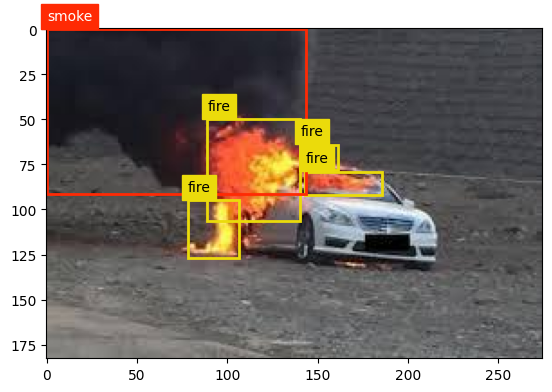

In [ ]:
from ultralytics.data.utils import visualize_image_annotations

img_id = 706
data_type = 'train'
labels_path = os.path.join(path, 'prepared_data', 'yolo_data', data_type, 'labels') 
images_path = os.path.join(path, 'prepared_data', 'yolo_data', data_type, 'images')
img_path = 'IMG_' + str(img_id) + '.jpg'
lbl_path = 'IMG_' + str(img_id) + '.txt'

visualize_image_annotations(os.path.join(images_path, img_path), os.path.join(labels_path, lbl_path), {0 : 'smoke', 1 : 'fire'})